In [1]:
import tensorflow as tf
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

In [2]:
num_predictors = 2
num_samples = 50

labels = np.zeros((num_samples), np.float32)
inputs = np.zeros((num_samples, num_predictors), np.float32)

max_coord = 10

for i in range(num_samples):
    x = np.random.randint(-max_coord, max_coord+1, (2))
    y = 1 if np.prod(x) >= 0 else -1
    inputs[i] = x
    labels[i] = y

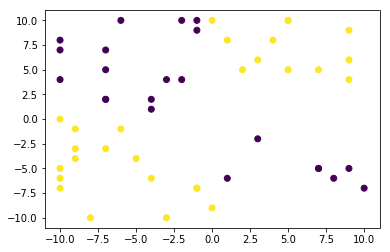

In [3]:
plt.scatter(inputs[:, 0], inputs[:, 1], c= labels)
plt.show()

In [34]:
def rbf_kernel(a, b, gamma=0.1, norm_func=tf.norm):
    return gamma * norm_func(a-b)**2

In [66]:
tf.reset_default_graph()
num_training = 30
train_inputs = inputs[:num_training]
train_labels = labels[:num_training]

kernel_matrix = np.zeros((num_training, num_training), np.float32)
for i in range(num_training):
    for j in range(num_training):
        kernel_matrix[i, j] = rbf_kernel(train_inputs[i], train_inputs[j], norm_func=np.linalg.norm)


pl_infer = tf.placeholder(tf.float32, [num_predictors])

weight = tf.get_variable("weight", [num_training])
bias = 0

decision_func = tf.math.sign( bias + tf.reduce_sum(
        weight * tf.map_fn(
                            lambda sample: rbf_kernel(pl_infer, sample),
                            train_inputs
        )
))





## Objective based on Dual Formulation (something I don't  yet understand)

In [133]:
penalty = 100000
C = 10000000
label_prod = weight * train_labels

objective = (1/2)*tf.tensordot( tf.tensordot(weight, kernel_matrix, axes=1), weight, axes=1)
objective -= tf.reduce_sum(label_prod)

#Implement constraints by using a penalty for if the constraints are violated

#Weights should sum to 0 under the constraints
weight_sum = tf.reduce_sum(weight)
objective += penalty * tf.math.abs(weight_sum)

#Must have 0 <= label_prod <= C
c_violation = tf.reduce_sum( tf.nn.relu(label_prod - C) + tf.nn.relu(-label_prod) )
objective += penalty * c_violation

train_op = tf.train.AdamOptimizer().minimize(objective)

In [143]:
loss = float("inf")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    while loss >= 5:
        [loss, _] = sess.run([objective, train_op])
    print("loss =", loss)
    [alpha_sum, c_viol] = sess.run([weight_sum, c_violation])
    print("alpha_sum =", alpha_sum, ", c_viol =", c_viol)
    
    train_accuracy = 0
    for i in range(len(train_inputs)):
        x = train_inputs[i]
        y = train_labels[i]
        prediction = sess.run(decision_func, {pl_infer: x})
        if y == prediction: train_accuracy += 1
        #print(prediction, "vs.", y)
    train_accuracy /= len(train_inputs)
    print("train_accuracy =", train_accuracy)

loss = -2.7905989
alpha_sum = -0.0016950071 , c_viol = 0.0
train_accuracy = 0.3333333333333333
